In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from itertools import product
from dataclasses import dataclass
from collections import namedtuple, defaultdict
from tasks.markov import *
from models.base_models import *
from models.pos_encoder import *
from tasks.causal_graph import *
from config import *
from train import *
import figures.plot as plot
from util import memory_recall_probe, feedforward_probe, activation_probe
import seaborn as sns
import torch.utils.benchmark as benchmark
from tqdm.notebook import tqdm, trange

from figures.head_view import *

torch.set_printoptions(precision=3, sci_mode=False)

%load_ext autoreload
%autoreload 2

In [129]:
def probe_ff(tokens, mlp_layer, model, sampler):
    toks = model.embed(torch.tensor(tokens, device="cuda"))
    mlp_out = model.layers[mlp_layer].mlp(toks)
    toks += mlp_out
    toks = model.output_layer(toks)
    probs = nn.Softmax(-1)(toks)
    print("TV distance: ", (probs - sampler.trans_mat[tokens]).abs().sum(dim=-1).detach().cpu())
    print("KL divergence: ", F.kl_div(sampler.trans_mat[tokens].log(), probs, reduction='none').sum(dim=-1).detach().cpu())

def memory_check(token, model, sampler):
    batch, mask, triggers, _ = sampler.test()
    while (batch == token).sum() == 0 or token in triggers:
        batch, mask, triggers, _  = sampler.test()
    probs = nn.Softmax(-1)(model(batch)[0])[batch==token]
    batch = batch.squeeze(0)
    indices = (batch == token).nonzero(as_tuple=True)[0]

    valid_pairs = []
    for idx in indices:
        if idx + 1 < len(batch):  # Ensure there is a next token
            valid_pairs.append((batch[idx].item(), batch[idx + 1].item()))
    
    print(valid_pairs)
    
    TV_dist = (probs - sampler.trans_mat[token].unsqueeze(0)).abs().sum(dim=-1).detach().cpu()
    KL_div = F.kl_div(sampler.trans_mat[token].log().unsqueeze(0), probs, reduction='none').sum(dim=-1).detach().cpu()
    print("TV distance: ", TV_dist)
    print("KL divergence: ", KL_div)

def generalization_check(sampler, model):
    batch, mask, triggers, out_probs = sampler.test()
    out_probs += 1e-4
    out_probs /= out_probs.sum(-1, keepdim=True)

    tokens = torch.arange(sampler.num_states)
    for trigger in triggers:
        tokens[trigger.item()] = -1

    counter = 1
    pairs = defaultdict(set)
    batch_squeezed = batch.squeeze(0).cpu().numpy()
    
    for i in range(len(batch_squeezed)-1):
        pair = (batch_squeezed[i], batch_squeezed[i+1])
        if (tokens[batch_squeezed[i]] != -1) and (pair not in pairs[batch_squeezed[i]]):
            if len(pairs[batch_squeezed[i]]) == 1:
                tokens[batch_squeezed[i]] = -1
            else:
                pairs[batch_squeezed[i]].add(pair)
        counter += 1
        if tokens.sum() == -sampler.num_states:
            break

    print("All non-triggers can be determined at step: ", counter)
    
    for i, trigger in enumerate(triggers):
        print("Trigger: ", trigger.item())
        probs = nn.Softmax(-1)(model(batch)[0].squeeze())[(mask[0]==1) & (batch[0]==trigger)]
        indices = (batch[0]==trigger).nonzero(as_tuple=True)[0]
        print(probs)
        print("The trigger occurs at: ", indices)
        TV_dist = (probs - out_probs[i].unsqueeze(0)).abs().sum(dim=-1).detach().cpu()
        KL_div = F.kl_div(out_probs[i].log().unsqueeze(0), probs, reduction='none').sum(dim=-1).detach().cpu()
        print("TV distance: ", TV_dist)
        print("KL divergence: ", KL_div)

In [57]:
def run_exp(SEQ_LEN, VOC_SIZE, BATCH_SIZE, rho, alpha, fixed, pos_enc, task_name, mlp_layer=None, epochs=10000, num_layers=2):

    flash = False
    
    if pos_enc in ["rotary", "abs"]:
        flash = True

    if mlp_layer is None:
        mlp_layer = num_layers - 1
        
    mlp = [False] * num_layers
    if mlp_layer < num_layers:
        mlp[mlp_layer] = True 
    mlp = tuple(mlp)
    print(mlp)
    
    config = Config(
            emb_dim=128,
            num_layers=num_layers,
            num_heads=tuple([1]*num_layers),
            identity_query=False,
            seq_len=SEQ_LEN,
            vocab_size=VOC_SIZE,
            batch_size=BATCH_SIZE,
            num_epochs=epochs,
            eval_iter=1000,
            pos_enc=pos_enc,
            pos_max_len=SEQ_LEN,
            get_attn=50,
            get_checkpoints=600,
            mlp=mlp,
            activation=mlp,
            flash=flash, # Use rotary
            ff_dim=128,
            layer_norm=False,
            ngram=2,
            learning_rate=1e-4,
            task_name=task_name
        )

    if task_name == "bietti":
        sampler_config = BiettiSamplerConfig(seq_len=SEQ_LEN, vocab_size=VOC_SIZE, batch_size=BATCH_SIZE, k=int(rho*VOC_SIZE), 
                                             alpha=alpha, fixed=fixed, task_name=task_name)
    else:
        sampler_config = MarkovSamplerConfig(seq_len=SEQ_LEN, vocab_size=VOC_SIZE, batch_size=BATCH_SIZE, rho=rho, alpha=alpha, fixed=fixed, order=1,
                                             task_name=task_name)
    
    model = Transformer(config)
    model = model.to(config.device)

    train_results = train_model_with_plot(model, config, sampler_config, show=True)

    return train_results, model, config, sampler_config

### Remark at the beginning

When the trigger tokens are fixed, the attention pattern is not necessarily a clean Induction Head, since the TF can make use of the token embedding information. Below, we focus on the case where the trigger tokens are random.

### Bietti: Small Vocabulary Size

(False, True)
Max size:  32500
Layer: 1


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

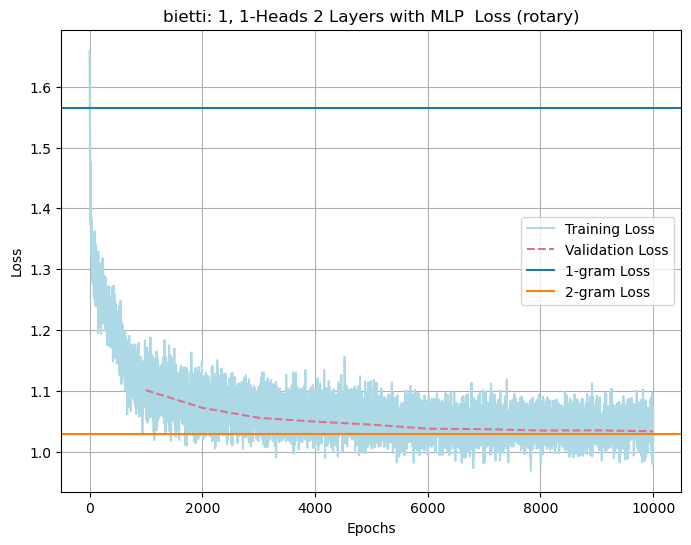

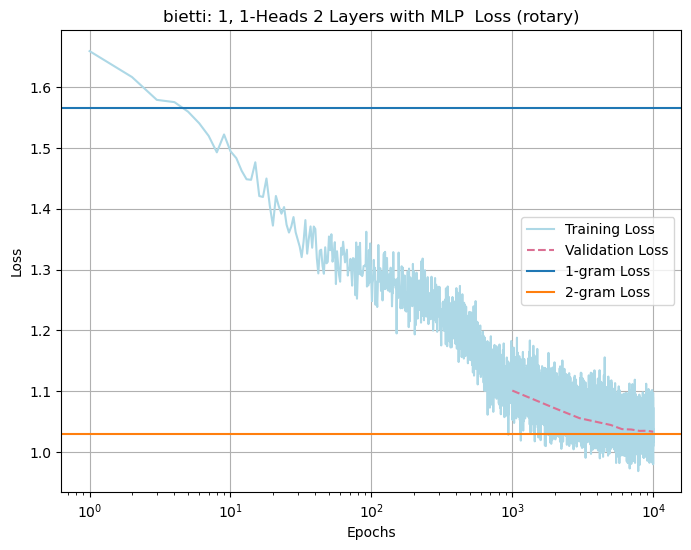

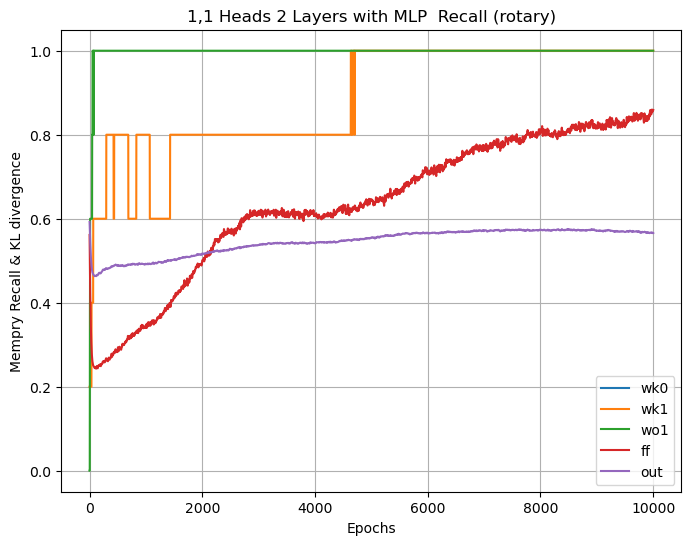

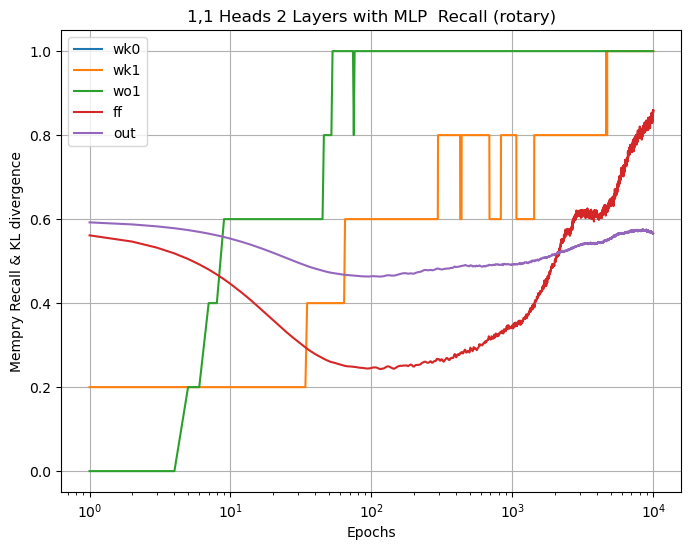

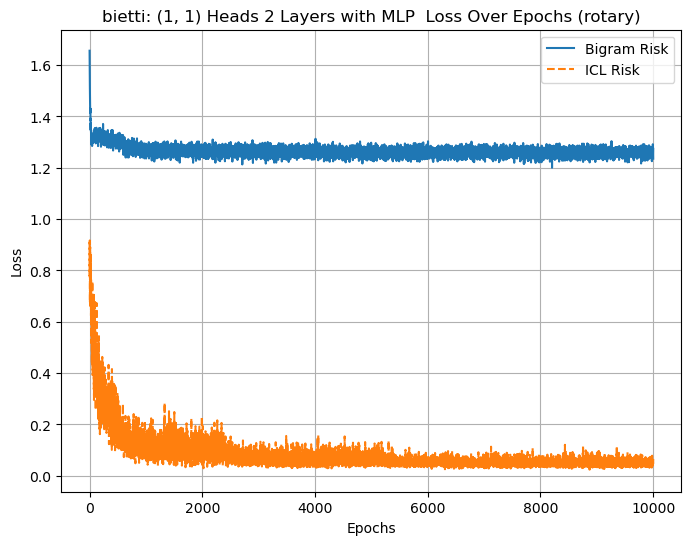

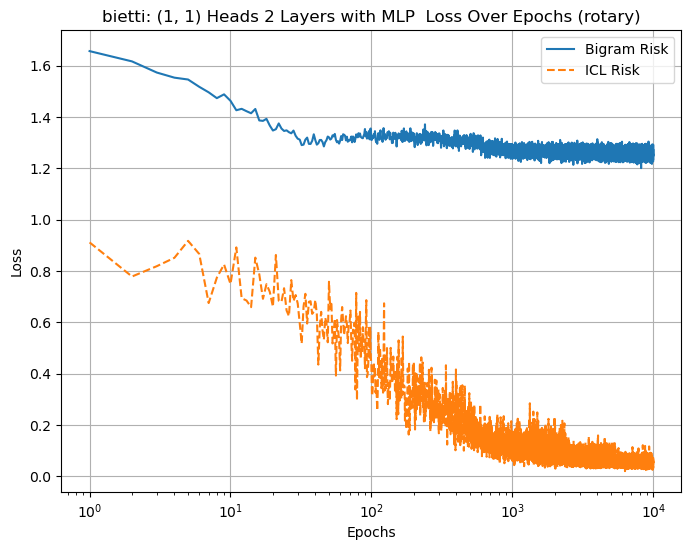

Creating images:   0%|          | 0/29 [00:00<?, ?it/s]

Creating images:   0%|          | 0/29 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

In [122]:
SEQ_LEN = 128
VOC_SIZE = 5
BATCH_SIZE = 32
rho = 0.2
alpha = 1
train_results, model, config, sampler_config = run_exp(SEQ_LEN, VOC_SIZE, BATCH_SIZE, rho, alpha, fixed=False, num_layers=2,
                                                       pos_enc="rotary", task_name="bietti", epochs=10000)

In [136]:
tokens = [3,4]
assert all(torch.tensor(tokens) < VOC_SIZE), "Check tokens, cannot exceed vocab size"
probe_ff(tokens, 1, model, train_results["sampler"])

TV distance:  tensor([0.588, 0.318])
KL divergence:  tensor([0.335, 0.121])


One sees that MLP is not necessarily for memorization when the vocabulary size is small.

#### Observation 1.

For non-trigger token, there is a mechanism to look back and see whether the current token is followed by different tokens. If not, TF will increase the chance of the repeated token; otherwise, it will **nearly discard the in-context information** and stick to the bigram transition learned so far.

In [151]:
token = 1
assert token < VOC_SIZE, "Check the token, cannot exceed vocab size"
memory_check(token, model, train_results["sampler"])

triggers:  tensor([[1]], device='cuda:0')
outputs:  tensor([[4]], device='cuda:0')
triggers:  tensor([[1]], device='cuda:0')
outputs:  tensor([[0]], device='cuda:0')
triggers:  tensor([[4]], device='cuda:0')
outputs:  tensor([[3]], device='cuda:0')
[(1, 2), (1, 2), (1, 4), (1, 4), (1, 2), (1, 4), (1, 4), (1, 2), (1, 4), (1, 2), (1, 2), (1, 1), (1, 2), (1, 2), (1, 4), (1, 4), (1, 4), (1, 4), (1, 2), (1, 2), (1, 4), (1, 4), (1, 2), (1, 4), (1, 4), (1, 0)]
TV distance:  tensor([0.132, 0.340, 0.691, 0.072, 0.028, 0.028, 0.027, 0.029, 0.028, 0.023,
        0.024, 0.029, 0.043, 0.052, 0.083, 0.026, 0.044, 0.051, 0.024, 0.033,
        0.043, 0.026, 0.020, 0.028, 0.021, 0.020])
KL divergence:  tensor([    0.016,     0.076,     0.287,     0.005,     0.001,     0.001,
            0.001,     0.001,     0.001,     0.000,     0.000,     0.001,
            0.002,     0.003,     0.007,     0.001,     0.001,     0.002,
            0.000,     0.001,     0.001,     0.000,     0.000,     0.000,
         

#### Observation 2.

For the trigger token, it is hard to tell whether it makes use of the information that other tokens are known to be non-triggers. 

In [150]:
generalization_check(train_results["sampler"], model)

triggers:  tensor([[1]], device='cuda:0')
outputs:  tensor([[0]], device='cuda:0')
All non-triggers can be determined at step:  74
Trigger:  1
tensor([[    0.080,     0.105,     0.226,     0.062,     0.527],
        [    0.596,     0.033,     0.085,     0.031,     0.255],
        [    0.958,     0.003,     0.010,     0.004,     0.025],
        [    0.980,     0.001,     0.005,     0.002,     0.012],
        [    0.993,     0.000,     0.002,     0.001,     0.004],
        [    0.998,     0.000,     0.001,     0.000,     0.001],
        [    0.999,     0.000,     0.000,     0.000,     0.001],
        [    0.999,     0.000,     0.000,     0.000,     0.001],
        [    0.999,     0.000,     0.000,     0.000,     0.000],
        [    1.000,     0.000,     0.000,     0.000,     0.000],
        [    1.000,     0.000,     0.000,     0.000,     0.000],
        [    1.000,     0.000,     0.000,     0.000,     0.000],
        [    1.000,     0.000,     0.000,     0.000,     0.000],
        [   

In [58]:
train_results["sampler"].trans_mat[1]

tensor([0.186, 0.555, 0.005, 0.075, 0.050, 0.129], device='cuda:0')

### Observation 3

Earlier model already has the capability to memorize, but not yet has the ability to learn in-context well. Early model seems to have the ability to determine whether to discard in-context information.

In [140]:
model_ckpt = Transformer(config)
checkpoint = torch.load("checkpoints/bietti/20250216_2354/model_1200.pt", weights_only=True)
model_ckpt.load_state_dict(checkpoint)
model_ckpt = model_ckpt.to(config.device)
generalization_check(train_results["sampler"], model_ckpt)

triggers:  tensor([[4]], device='cuda:0')
outputs:  tensor([[3]], device='cuda:0')
All non-triggers can be determined at step:  13
Trigger:  4
tensor([[0.286, 0.277, 0.031, 0.326, 0.079],
        [0.267, 0.276, 0.012, 0.384, 0.062],
        [0.222, 0.203, 0.003, 0.508, 0.064],
        [0.241, 0.232, 0.005, 0.464, 0.059],
        [0.258, 0.233, 0.007, 0.436, 0.066],
        [0.220, 0.209, 0.003, 0.504, 0.064],
        [0.230, 0.199, 0.005, 0.512, 0.053],
        [0.220, 0.209, 0.003, 0.506, 0.061],
        [0.215, 0.243, 0.004, 0.487, 0.051],
        [0.219, 0.204, 0.003, 0.514, 0.060],
        [0.208, 0.190, 0.005, 0.550, 0.048],
        [0.212, 0.193, 0.005, 0.539, 0.051],
        [0.213, 0.192, 0.003, 0.533, 0.058],
        [0.214, 0.194, 0.004, 0.529, 0.058],
        [0.214, 0.236, 0.004, 0.496, 0.051],
        [0.203, 0.190, 0.004, 0.556, 0.048],
        [0.210, 0.195, 0.004, 0.534, 0.057],
        [0.215, 0.195, 0.004, 0.530, 0.057],
        [0.198, 0.189, 0.004, 0.562, 0.046],
  

In [153]:
token = 3
assert token < VOC_SIZE, "Check the token, cannot exceed vocab size"
memory_check(token, model, train_results["sampler"])

triggers:  tensor([[4]], device='cuda:0')
outputs:  tensor([[3]], device='cuda:0')
[(3, 4), (3, 4), (3, 3), (3, 3), (3, 2), (3, 0), (3, 2), (3, 4), (3, 3), (3, 0), (3, 0), (3, 0), (3, 0), (3, 2), (3, 0), (3, 1), (3, 4), (3, 0), (3, 4), (3, 2), (3, 4), (3, 3), (3, 0), (3, 3), (3, 0), (3, 4), (3, 4), (3, 4), (3, 4), (3, 2), (3, 0), (3, 4), (3, 0), (3, 4), (3, 0), (3, 3), (3, 4), (3, 0), (3, 4), (3, 4), (3, 2)]
TV distance:  tensor([0.124, 0.259, 0.852, 0.098, 0.117, 0.058, 0.026, 0.038, 0.015, 0.082,
        0.040, 0.049, 0.029, 0.019, 0.028, 0.033, 0.012, 0.018, 0.019, 0.023,
        0.030, 0.036, 0.038, 0.020, 0.052, 0.026, 0.021, 0.020, 0.023, 0.025,
        0.030, 0.032, 0.036, 0.031, 0.038, 0.034, 0.011, 0.027, 0.028, 0.031,
        0.034, 0.043])
KL divergence:  tensor([    0.022,     0.043,     0.410,     0.005,     0.007,     0.002,
            0.001,     0.001,     0.000,     0.005,     0.001,     0.001,
            0.001,     0.000,     0.001,     0.001,     0.000,     0.000,
 

### Observation 4

The incontext ability fully kicked in around 1800 steps. 

In [152]:
model_ckpt = Transformer(config)
checkpoint = torch.load("checkpoints/bietti/20250216_2354/model_1800.pt", weights_only=True)
model_ckpt.load_state_dict(checkpoint)
model_ckpt = model_ckpt.to(config.device)
generalization_check(train_results["sampler"], model_ckpt)

triggers:  tensor([[0]], device='cuda:0')
outputs:  tensor([[1]], device='cuda:0')
All non-triggers can be determined at step:  15
Trigger:  0
tensor([[0.422, 0.336, 0.070, 0.010, 0.163],
        [0.249, 0.630, 0.032, 0.017, 0.072],
        [0.090, 0.851, 0.011, 0.012, 0.036],
        [0.076, 0.878, 0.009, 0.009, 0.027],
        [0.048, 0.919, 0.006, 0.007, 0.020],
        [0.051, 0.906, 0.008, 0.007, 0.027],
        [0.039, 0.928, 0.006, 0.007, 0.020],
        [0.025, 0.956, 0.003, 0.005, 0.011],
        [0.021, 0.962, 0.003, 0.004, 0.010],
        [0.044, 0.928, 0.006, 0.005, 0.018],
        [0.065, 0.898, 0.010, 0.005, 0.021],
        [0.050, 0.922, 0.008, 0.005, 0.016],
        [0.031, 0.946, 0.004, 0.005, 0.014],
        [0.035, 0.938, 0.005, 0.006, 0.016],
        [0.035, 0.940, 0.005, 0.006, 0.015],
        [0.020, 0.964, 0.003, 0.005, 0.009],
        [0.018, 0.967, 0.002, 0.004, 0.009],
        [0.020, 0.963, 0.003, 0.004, 0.010],
        [0.022, 0.960, 0.003, 0.004, 0.010],
  

### Bietti: Larger Vocabulary Size and Sparser Transition

In context learning seems impossible for random triggers. 

(False, True)
Max size:  16000
Layer: 1


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

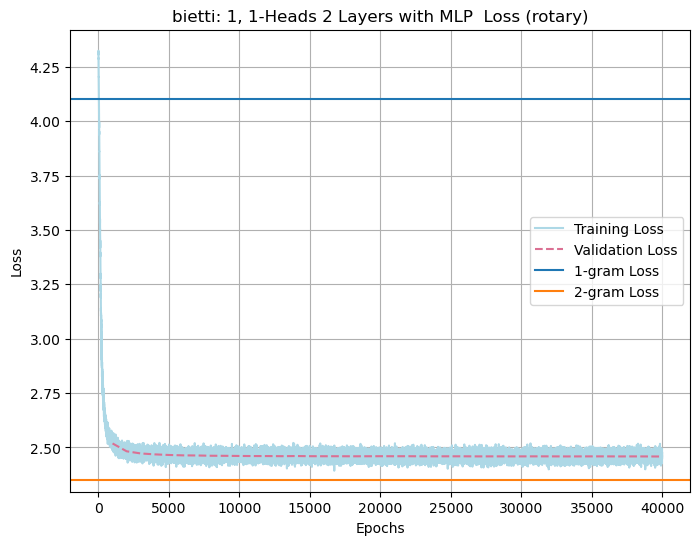

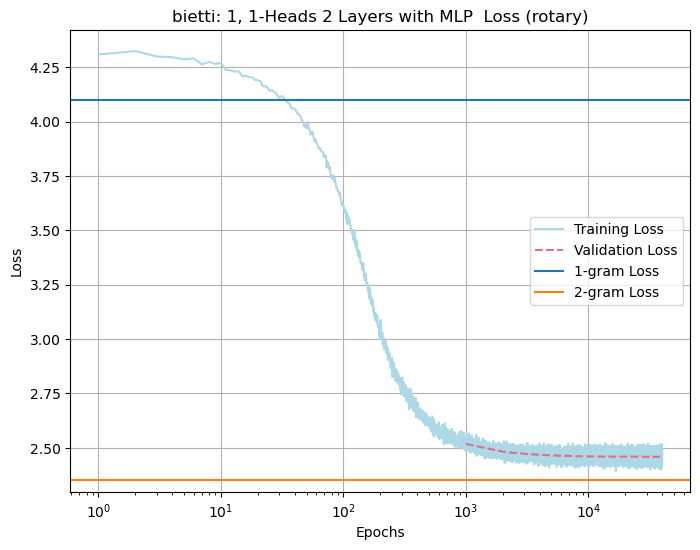

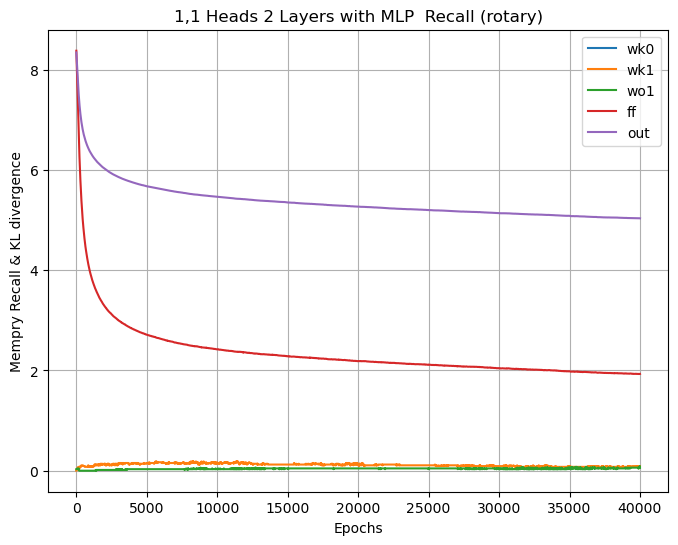

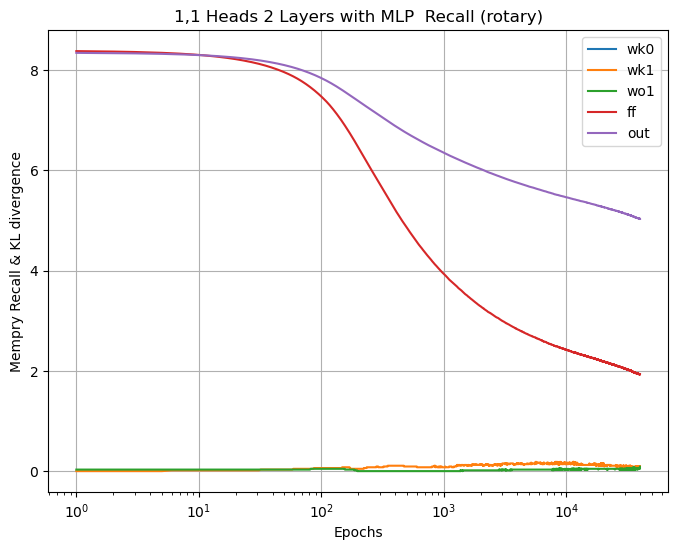

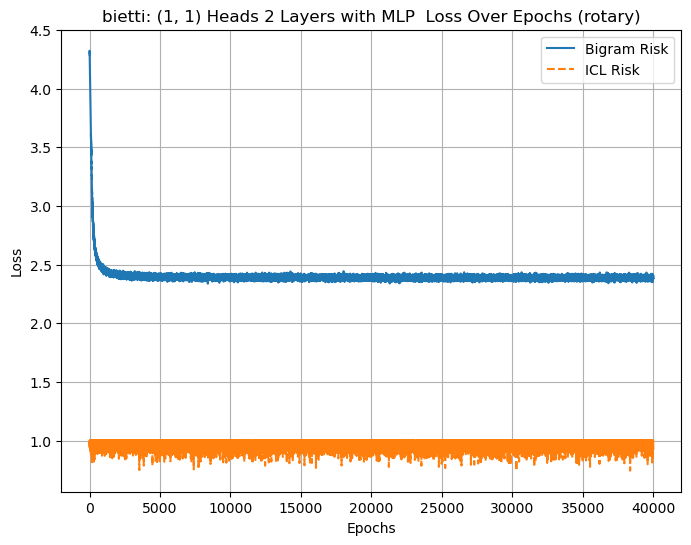

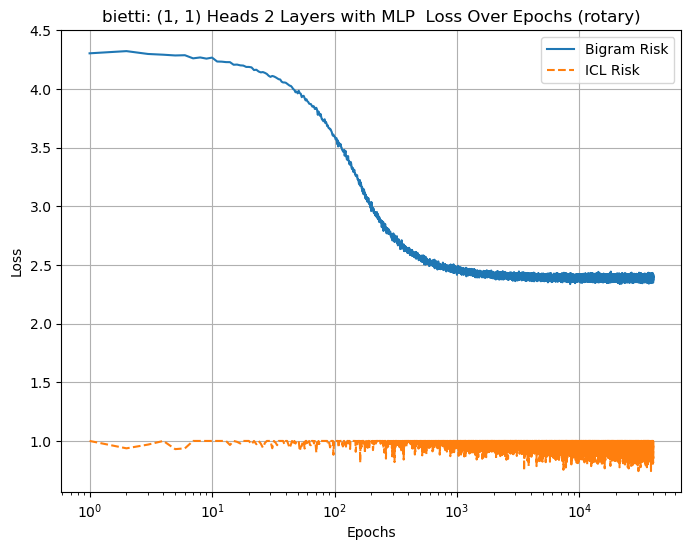

Creating images:   0%|          | 0/59 [00:00<?, ?it/s]

Creating images:   0%|          | 0/59 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

In [158]:
SEQ_LEN = 256
VOC_SIZE = 65
BATCH_SIZE = 32
rho = 0.02
alpha = 0.1
train_results, model, config, sampler_config = run_exp(SEQ_LEN, VOC_SIZE, BATCH_SIZE, rho, alpha, fixed=False, num_layers=2,
                                                       pos_enc="rotary", task_name="bietti", epochs=40000)

In [159]:
generalization_check(train_results["sampler"], model)

triggers:  tensor([[14]], device='cuda:0')
outputs:  tensor([[54]], device='cuda:0')
All non-triggers can be determined at step:  256
Trigger:  14
tensor([[    0.000,     0.002,     0.041,     0.000,     0.171,     0.001,
             0.132,     0.036,     0.010,     0.017,     0.000,     0.000,
             0.001,     0.000,     0.008,     0.000,     0.007,     0.003,
             0.005,     0.001,     0.000,     0.000,     0.000,     0.000,
             0.000,     0.000,     0.008,     0.008,     0.000,     0.003,
             0.170,     0.000,     0.000,     0.000,     0.049,     0.001,
             0.000,     0.000,     0.004,     0.000,     0.095,     0.001,
             0.000,     0.047,     0.009,     0.001,     0.000,     0.001,
             0.000,     0.000,     0.037,     0.000,     0.005,     0.001,
             0.000,     0.043,     0.000,     0.001,     0.000,     0.042,
             0.023,     0.000,     0.006,     0.001,     0.001],
        [    0.000,     0.002,     0.0

## RPE: MLP on First Layer

Random rows: tensor([1], device='cuda:0')
Layer: 0


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

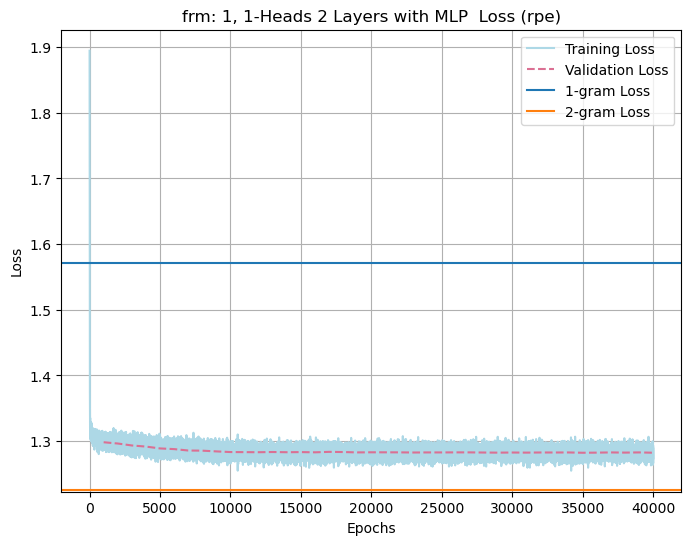

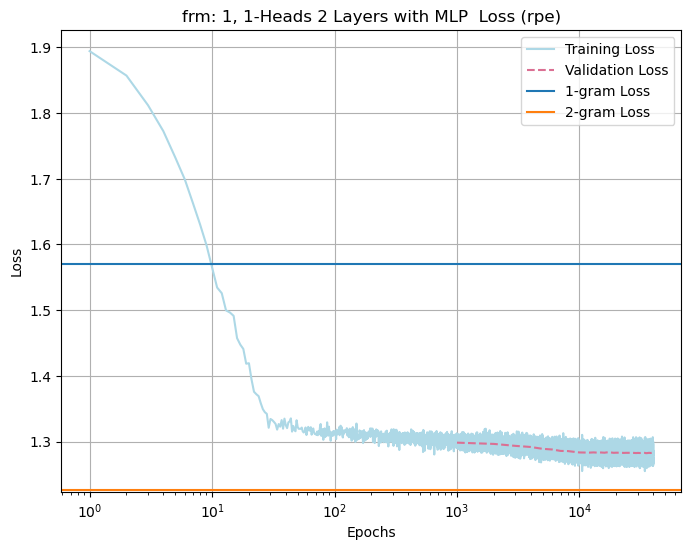

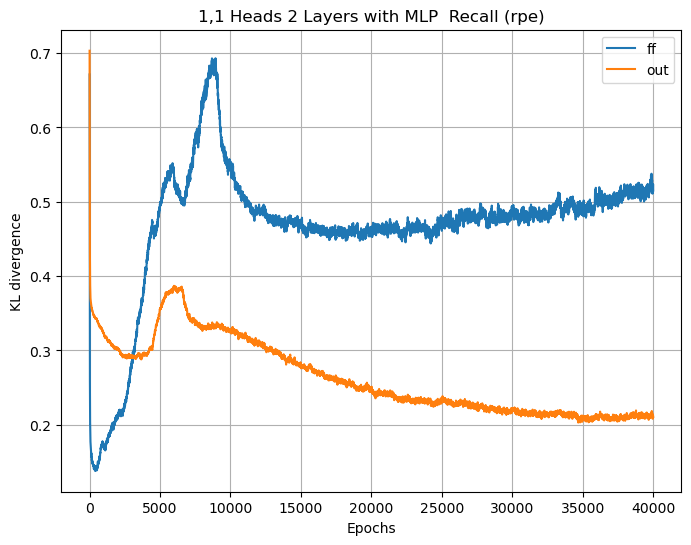

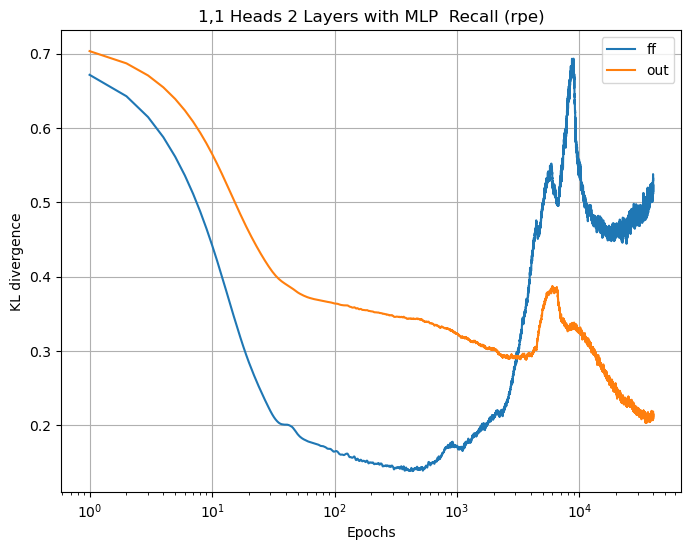

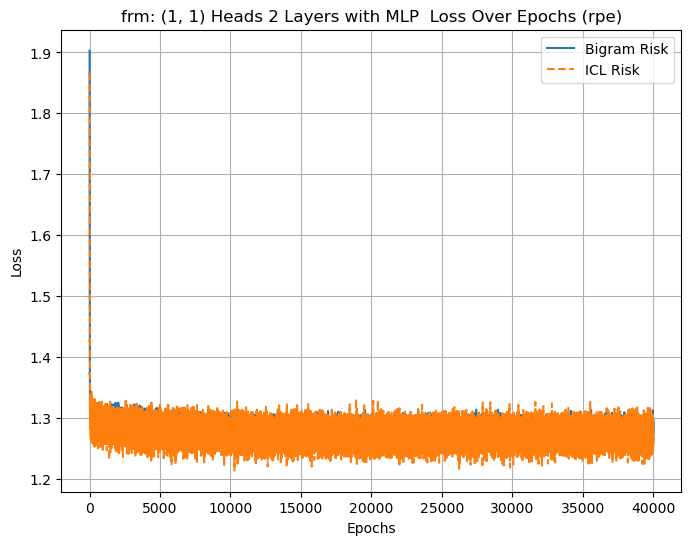

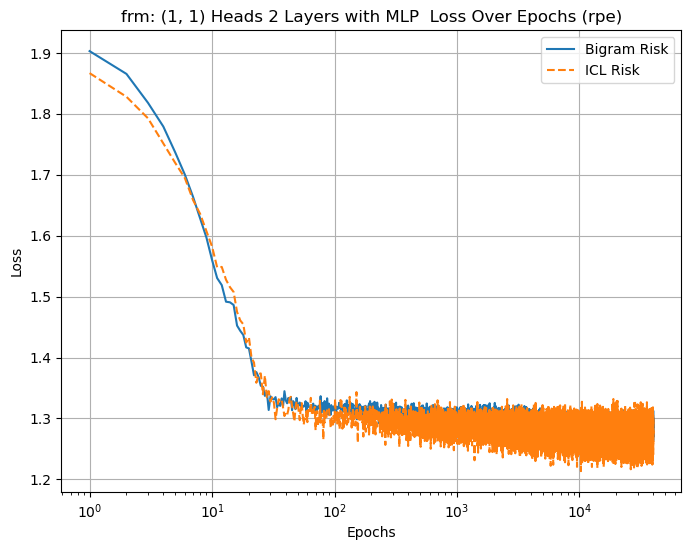

Creating images:   0%|          | 0/800 [00:00<?, ?it/s]

Creating images:   0%|          | 0/800 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

In [45]:
SEQ_LEN = 50
VOC_SIZE = 5
BATCH_SIZE = 256
rho = 0.2
alpha = 1
train_results, model = run_exp(SEQ_LEN, VOC_SIZE, BATCH_SIZE, rho, alpha, fixed=True, pos_enc="rpe", mlp_layer=0)

### Check Memorization for RPE

In [46]:
train_results["sampler"].base_trans_matrix[0]

tensor([0.21, 0.01, 0.19, 0.49, 0.09], device='cuda:0')

In [47]:
toks = model.embed(torch.tensor([0], device="cuda"))
mlp_out = model.layers[0].mlp(toks)
toks += mlp_out
toks = model.output_layer(toks)
probs = nn.Softmax(-1)(toks)
(probs.squeeze() - train_results["sampler"].base_trans_matrix[0]).abs()

tensor([0.21, 0.06, 0.06, 0.05, 0.04], device='cuda:0', grad_fn=<AbsBackward0>)

In [48]:
batch, mask = train_results["sampler"].test()
(nn.Softmax(-1)(model(batch)[0])[batch==0][-3:] - train_results["sampler"].base_trans_matrix[0].unsqueeze(0)).abs()

tensor([[[0.35, 0.05, 0.01, 0.42, 0.17]]], device='cuda:0')


tensor([[0.01, 0.00, 0.01, 0.00, 0.00],
        [0.01, 0.00, 0.01, 0.00, 0.00],
        [0.01, 0.00, 0.01, 0.00, 0.00]], device='cuda:0',
       grad_fn=<AbsBackward0>)

### Check Generalization for RPE

In [53]:
batch, mask = train_results["sampler"].test()

tensor([[[0.18, 0.15, 0.05, 0.38, 0.24]]], device='cuda:0')


In [54]:
nn.Softmax(-1)(model(batch)[0].squeeze())[mask[0]==1]

tensor([[0.20, 0.21, 0.20, 0.19, 0.20],
        [0.17, 0.17, 0.18, 0.31, 0.17],
        [0.15, 0.12, 0.17, 0.40, 0.15],
        [0.11, 0.11, 0.14, 0.50, 0.13],
        [0.11, 0.11, 0.13, 0.41, 0.23],
        [0.10, 0.11, 0.12, 0.48, 0.20],
        [0.09, 0.10, 0.10, 0.54, 0.17],
        [0.07, 0.09, 0.09, 0.59, 0.15],
        [0.07, 0.09, 0.09, 0.61, 0.14],
        [0.07, 0.09, 0.08, 0.65, 0.12]], device='cuda:0',
       grad_fn=<IndexBackward0>)

## RPE: MLP on Second Layer

Random rows: tensor([1], device='cuda:0')
Layer: 1


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

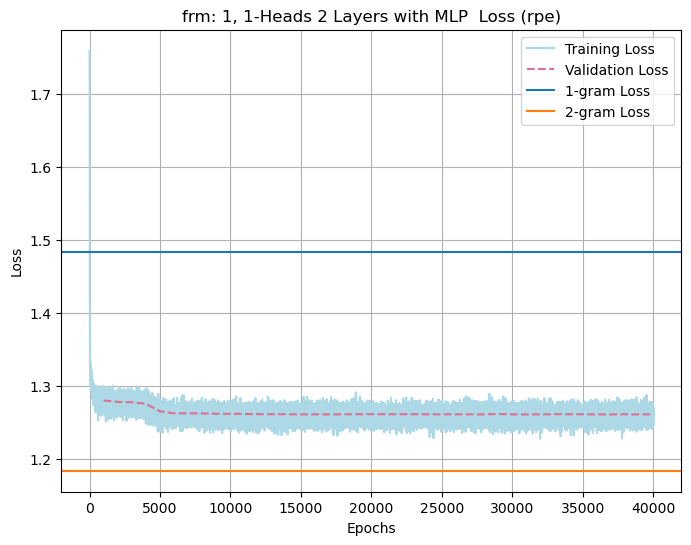

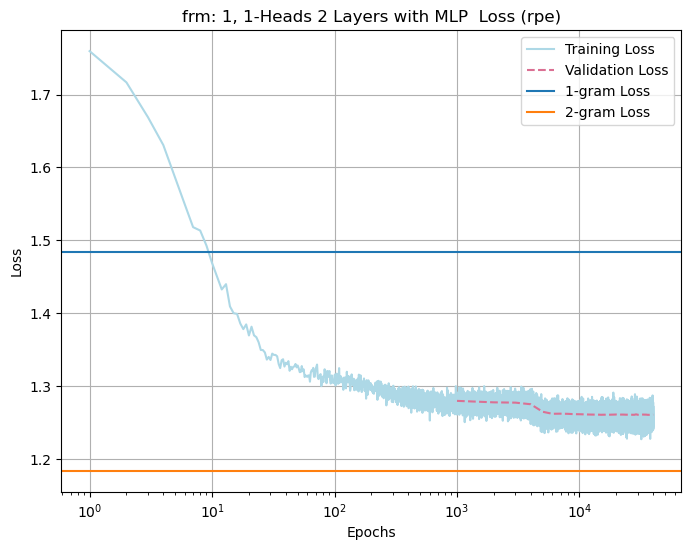

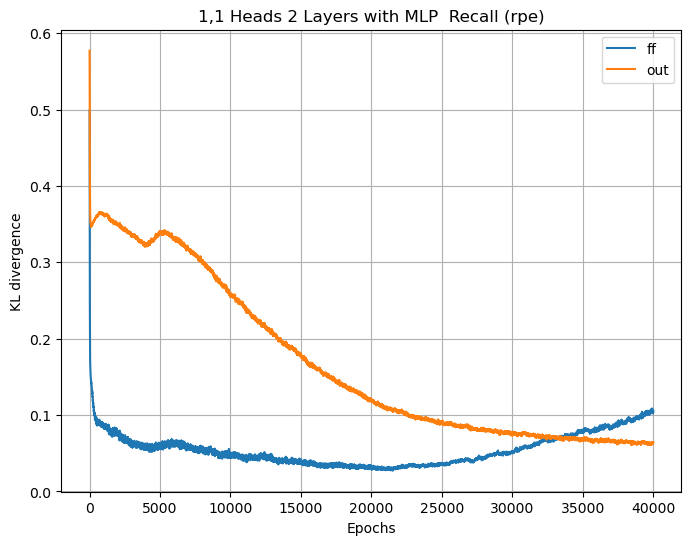

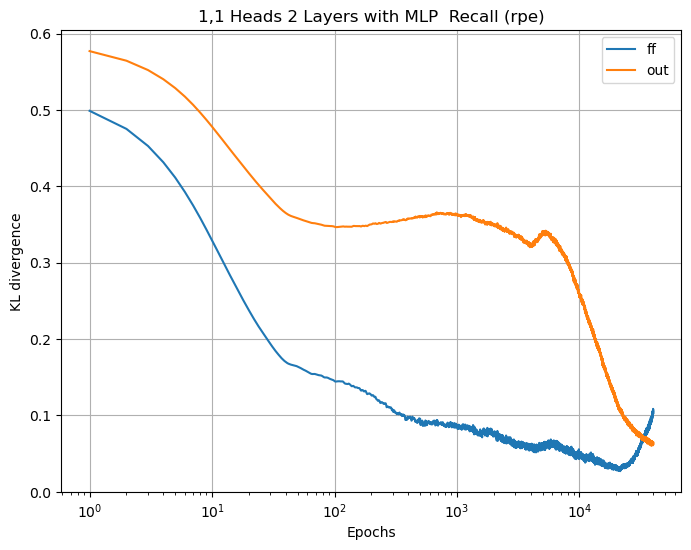

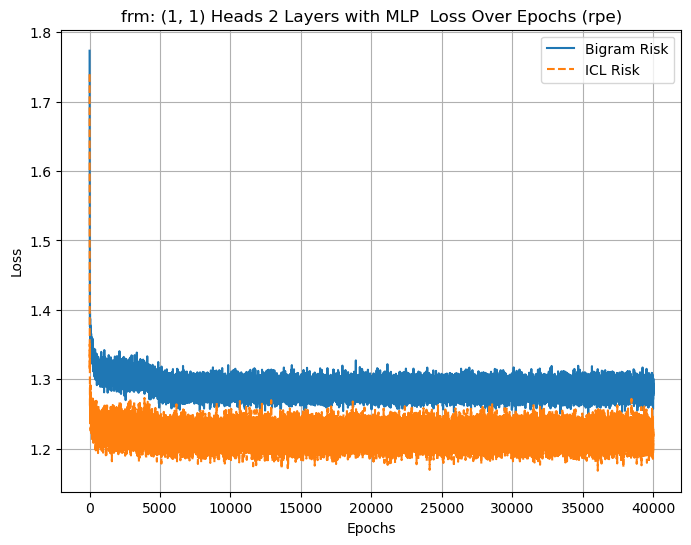

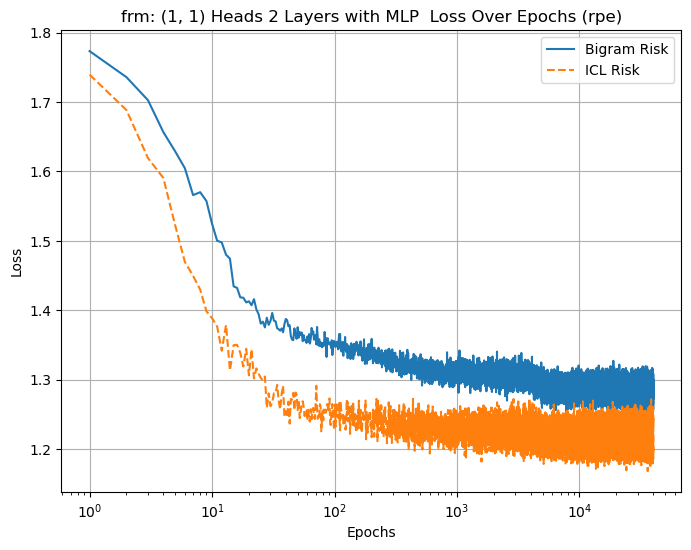

Creating images:   0%|          | 0/800 [00:00<?, ?it/s]

Creating images:   0%|          | 0/800 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

In [57]:
train_results, model = run_exp(SEQ_LEN, VOC_SIZE, BATCH_SIZE, rho, alpha, fixed=True, pos_enc="rpe", mlp_layer=1)

### Check Memorization for RPE

In [58]:
train_results["sampler"].base_trans_matrix[0]

tensor([0.10, 0.55, 0.11, 0.17, 0.08], device='cuda:0')

In [59]:
toks = model.embed(torch.tensor([0], device="cuda"))
mlp_out = model.layers[1].mlp(toks)
toks += mlp_out
toks = model.output_layer(toks)
probs = nn.Softmax(-1)(toks)
(probs.squeeze() - train_results["sampler"].base_trans_matrix[0]).abs()

tensor([0.04, 0.02, 0.03, 0.01, 0.02], device='cuda:0', grad_fn=<AbsBackward0>)

In [60]:
batch, mask = train_results["sampler"].test()
(nn.Softmax(-1)(model(batch)[0])[batch==0][-3:] - train_results["sampler"].base_trans_matrix[0].unsqueeze(0)).abs()

tensor([[[0.25, 0.17, 0.34, 0.09, 0.14]]], device='cuda:0')


tensor([[0.00, 0.01, 0.00, 0.00, 0.00],
        [0.00, 0.01, 0.00, 0.00, 0.00],
        [0.00, 0.01, 0.00, 0.00, 0.00]], device='cuda:0',
       grad_fn=<AbsBackward0>)

### Check Generalization for RPE

In [61]:
batch, mask = train_results["sampler"].test()

tensor([[[0.23, 0.07, 0.46, 0.07, 0.17]]], device='cuda:0')


In [62]:
nn.Softmax(-1)(model(batch)[0].squeeze())[mask[0]==1]

tensor([[0.20, 0.20, 0.19, 0.20, 0.20],
        [0.16, 0.18, 0.32, 0.17, 0.17],
        [0.14, 0.16, 0.43, 0.14, 0.14],
        [0.13, 0.13, 0.36, 0.13, 0.25],
        [0.11, 0.12, 0.43, 0.11, 0.22],
        [0.11, 0.10, 0.39, 0.11, 0.30],
        [0.10, 0.08, 0.44, 0.10, 0.28],
        [0.09, 0.08, 0.49, 0.10, 0.25],
        [0.08, 0.15, 0.45, 0.09, 0.23],
        [0.08, 0.14, 0.49, 0.08, 0.21],
        [0.07, 0.11, 0.53, 0.08, 0.20],
        [0.07, 0.18, 0.49, 0.07, 0.19],
        [0.07, 0.18, 0.51, 0.07, 0.18],
        [0.06, 0.16, 0.54, 0.07, 0.17],
        [0.11, 0.14, 0.52, 0.06, 0.16],
        [0.15, 0.12, 0.51, 0.06, 0.16],
        [0.15, 0.11, 0.53, 0.06, 0.15],
        [0.19, 0.10, 0.51, 0.06, 0.14],
        [0.18, 0.10, 0.48, 0.05, 0.18],
        [0.22, 0.09, 0.46, 0.05, 0.17]], device='cuda:0',
       grad_fn=<IndexBackward0>)

## RPE: MLP on Second Layer

Random rows: tensor([4], device='cuda:0')
Layer: 1


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

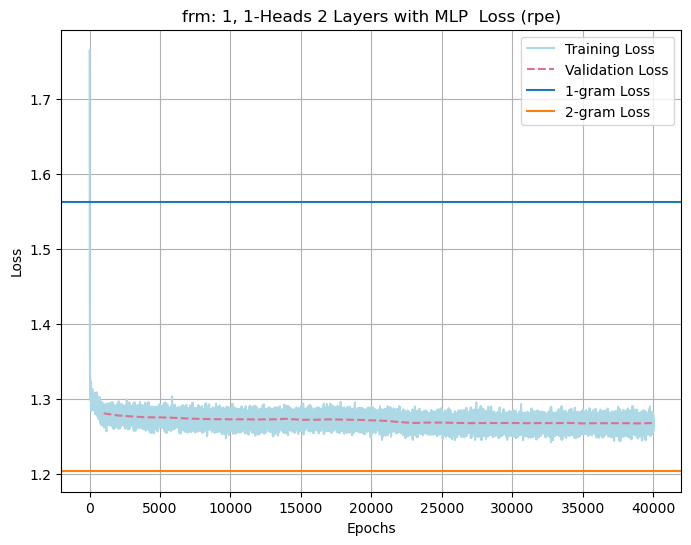

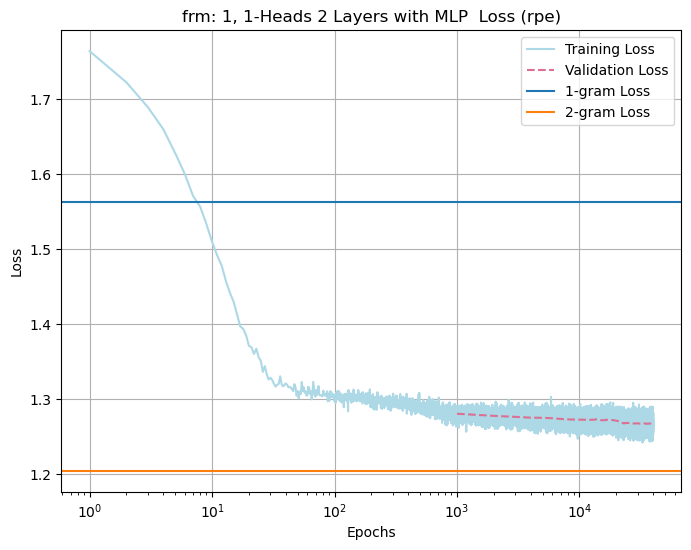

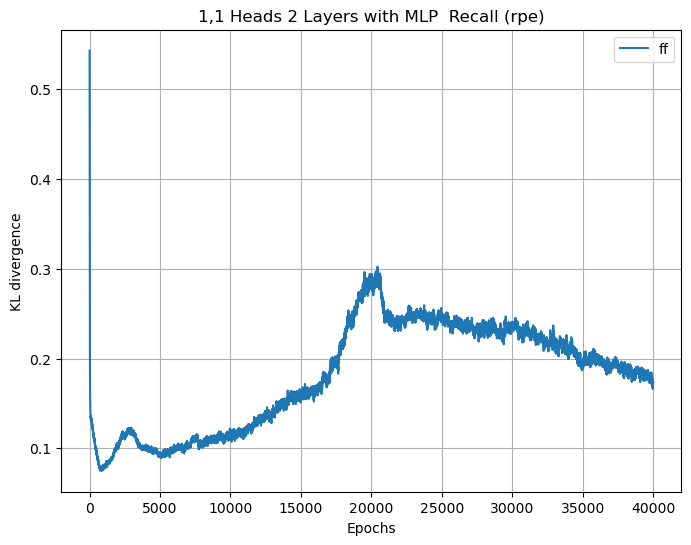

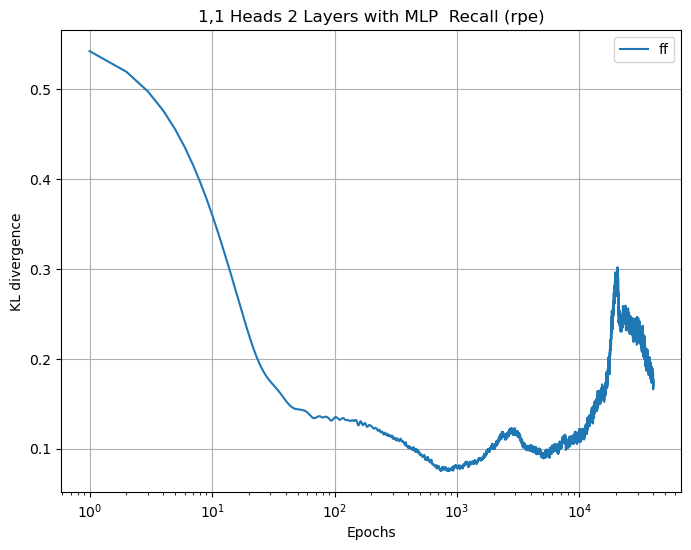

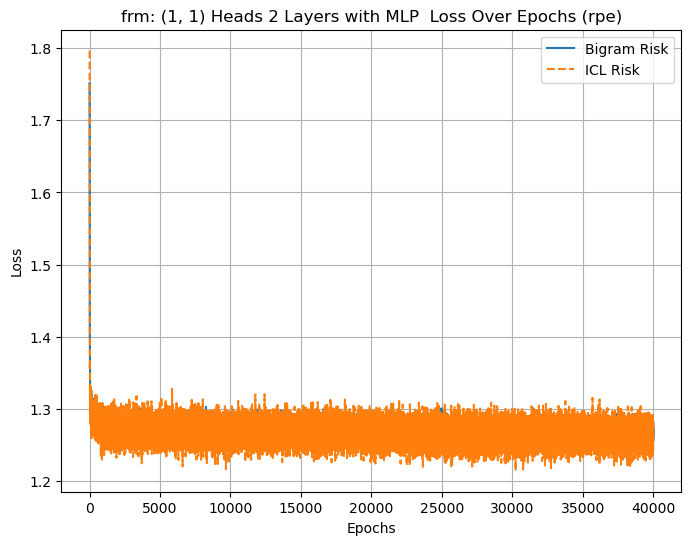

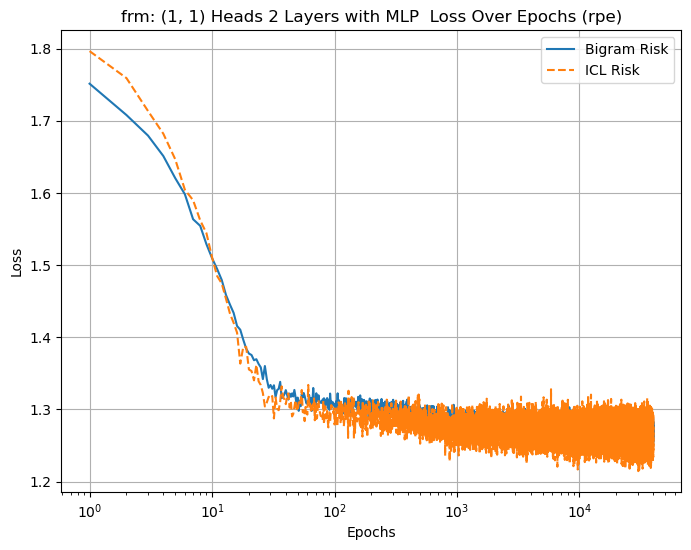

Creating images:   0%|          | 0/800 [00:00<?, ?it/s]

Creating images:   0%|          | 0/800 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

In [3]:
SEQ_LEN = 50
VOC_SIZE = 5
BATCH_SIZE = 256
rho = 0.2
alpha = 1
train_results, model = run_exp(SEQ_LEN, VOC_SIZE, BATCH_SIZE, rho, alpha, fixed=True, pos_enc="rpe", mlp_layer=1)

### Check Memorization for RPE

In [4]:
train_results["sampler"].base_trans_matrix[0]

tensor([0.03, 0.05, 0.40, 0.01, 0.51], device='cuda:0')

In [5]:
toks = model.embed(torch.tensor([0], device="cuda"))
mlp_out = model.layers[1].mlp(toks)
toks += mlp_out
toks = model.output_layer(toks)
probs = nn.Softmax(-1)(toks)
(probs.squeeze() - train_results["sampler"].base_trans_matrix[0]).abs()

tensor([0.01, 0.01, 0.03, 0.01, 0.02], device='cuda:0', grad_fn=<AbsBackward0>)

In [6]:
batch, mask = train_results["sampler"].test()
(nn.Softmax(-1)(model(batch)[0])[batch==0][-3:] - train_results["sampler"].base_trans_matrix[0].unsqueeze(0)).abs()

tensor([[[0.43, 0.15, 0.04, 0.12, 0.26]]], device='cuda:0')


tensor([[    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.01,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00]], device='cuda:0',
       grad_fn=<AbsBackward0>)

### Check Generalization for RPE

In [7]:
batch, mask = train_results["sampler"].test()

tensor([[[0.03, 0.23, 0.29, 0.29, 0.17]]], device='cuda:0')


In [8]:
nn.Softmax(-1)(model(batch)[0].squeeze())[mask[0]==1]

tensor([[0.20, 0.19, 0.19, 0.21, 0.20],
        [0.17, 0.16, 0.15, 0.17, 0.35],
        [0.14, 0.14, 0.14, 0.28, 0.29],
        [0.13, 0.13, 0.23, 0.25, 0.26],
        [0.12, 0.11, 0.31, 0.22, 0.24],
        [0.11, 0.11, 0.28, 0.21, 0.30],
        [0.09, 0.10, 0.32, 0.18, 0.30],
        [0.08, 0.09, 0.29, 0.26, 0.28],
        [0.08, 0.08, 0.35, 0.24, 0.25],
        [0.08, 0.07, 0.39, 0.22, 0.24],
        [0.07, 0.07, 0.36, 0.27, 0.22],
        [0.06, 0.13, 0.34, 0.26, 0.20],
        [0.06, 0.12, 0.32, 0.30, 0.19]], device='cuda:0',
       grad_fn=<IndexBackward0>)

## Rotary: MLP on Second Layer

Random rows: tensor([2], device='cuda:0')
Layer: 1


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

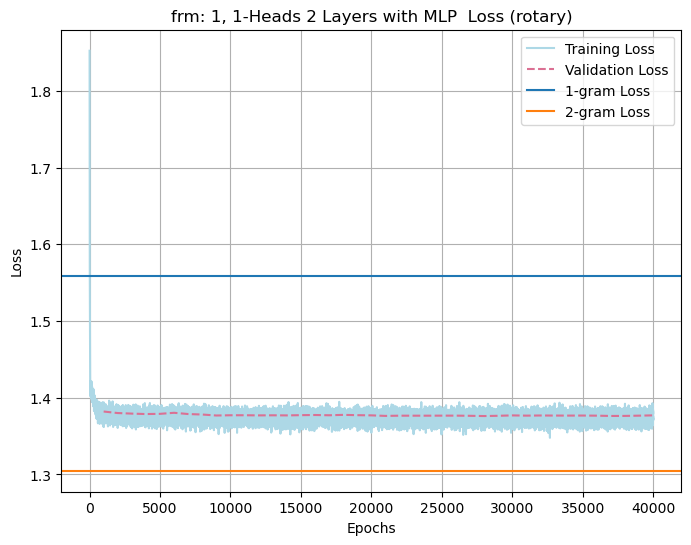

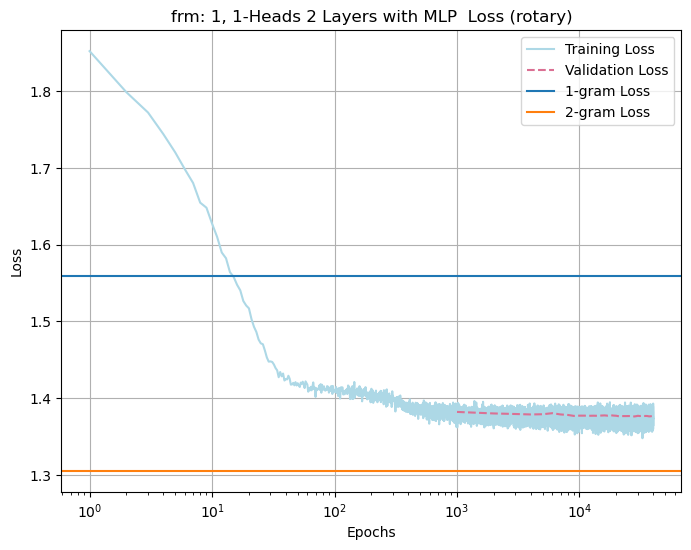

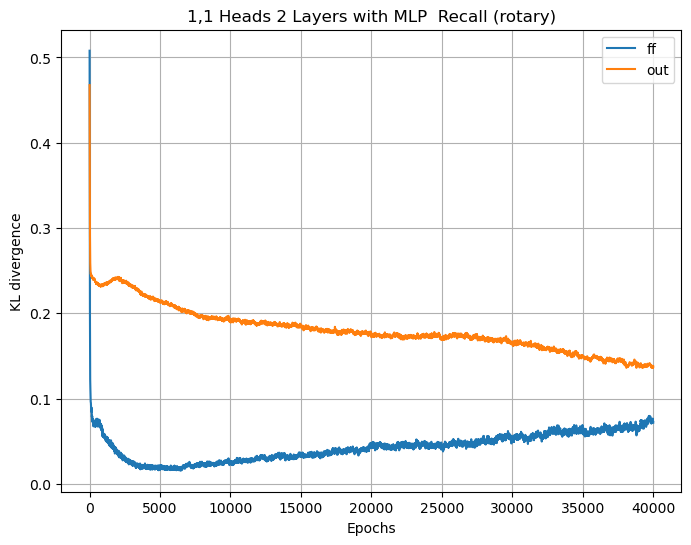

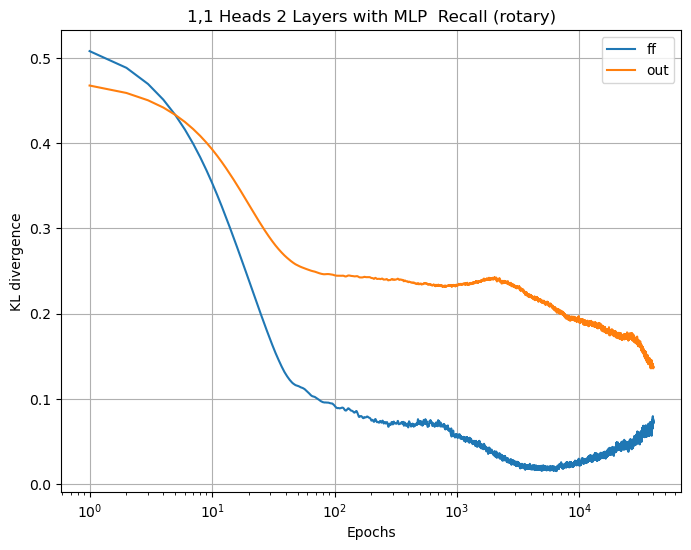

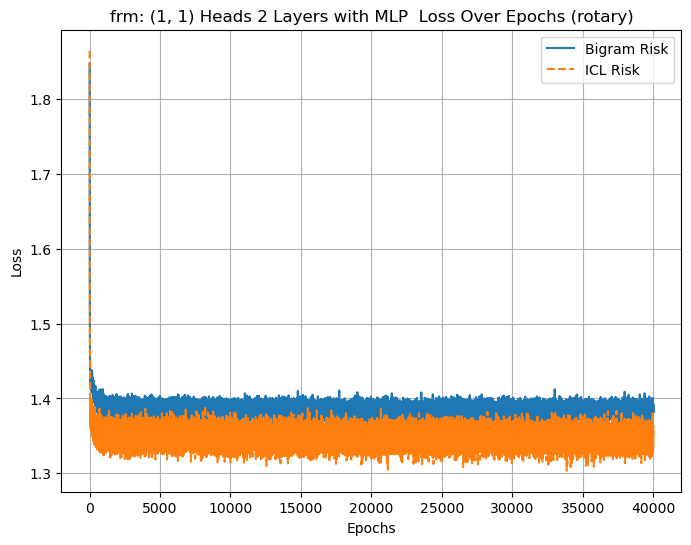

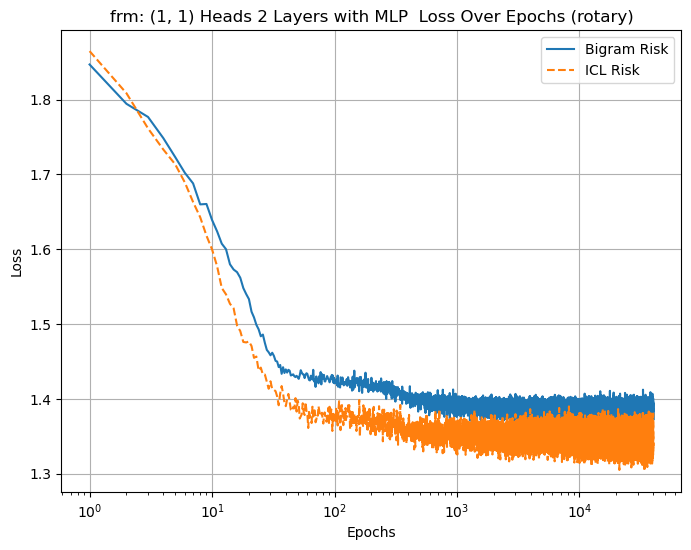

Creating images:   0%|          | 0/800 [00:00<?, ?it/s]

Creating images:   0%|          | 0/800 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

In [63]:
train_results, model = run_exp(SEQ_LEN, VOC_SIZE, BATCH_SIZE, rho, alpha, fixed=True, pos_enc="rotary", mlp_layer=1)

### Check Memorization for Rotary

In [64]:
train_results["sampler"].base_trans_matrix[0]

tensor([0.06, 0.29, 0.27, 0.02, 0.36], device='cuda:0')

In [65]:
toks = model.embed(torch.tensor([0], device="cuda"))
mlp_out = model.layers[1].mlp(toks)
toks += mlp_out
toks = model.output_layer(toks)
probs = nn.Softmax(-1)(toks)
(probs.squeeze() - train_results["sampler"].base_trans_matrix[0]).abs()

tensor([0.03, 0.00, 0.06, 0.01, 0.07], device='cuda:0', grad_fn=<AbsBackward0>)

In [66]:
batch, mask = train_results["sampler"].test()
(nn.Softmax(-1)(model(batch)[0])[batch==0][-3:] - train_results["sampler"].base_trans_matrix[0].unsqueeze(0)).abs()

tensor([[[0.31, 0.09, 0.13, 0.31, 0.16]]], device='cuda:0')


tensor([[0.00, 0.00, 0.00, 0.00, 0.00],
        [0.00, 0.00, 0.01, 0.00, 0.01],
        [0.00, 0.00, 0.00, 0.00, 0.00]], device='cuda:0',
       grad_fn=<AbsBackward0>)

### Check Generalization for Rotary

In [69]:
batch, mask = train_results["sampler"].test()
batch, mask

tensor([[[0.11, 0.29, 0.20, 0.04, 0.36]]], device='cuda:0')


(tensor([[1, 0, 4, 0, 4, 4, 2, 4, 4, 2, 1, 2, 4, 1, 0, 2, 4, 4, 1, 1, 0, 1, 2, 0,
          2, 4, 0, 4, 0, 4, 0, 4, 1, 2, 2, 2, 4, 2, 4, 4, 0, 2, 1, 3, 1, 1, 2, 1,
          3, 2]], device='cuda:0'),
 tensor([[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
          1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
          0, 0]], device='cuda:0'))

In [ ]:
nn.Softmax(-1)(model(batch)[0].squeeze())[mask[0]==1]

## Rotary: MLP on Second Layer

Random rows: tensor([0], device='cuda:0')
Layer: 1


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

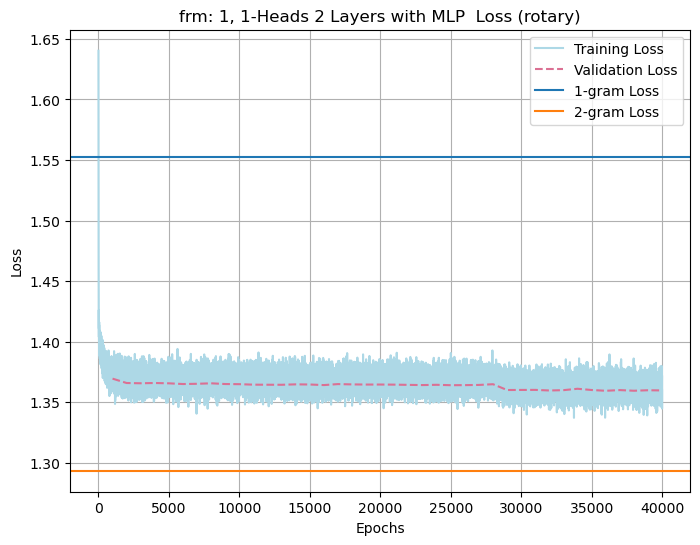

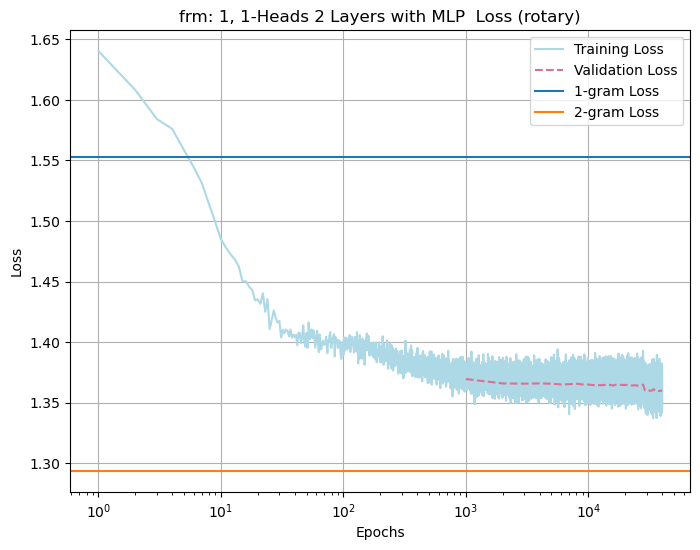

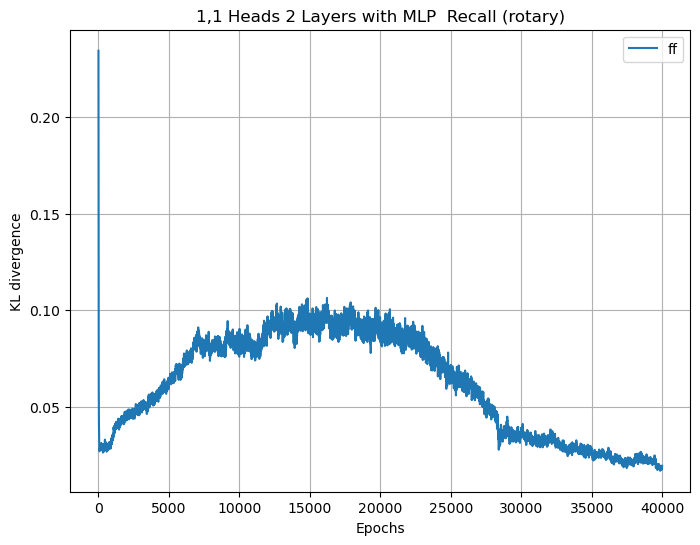

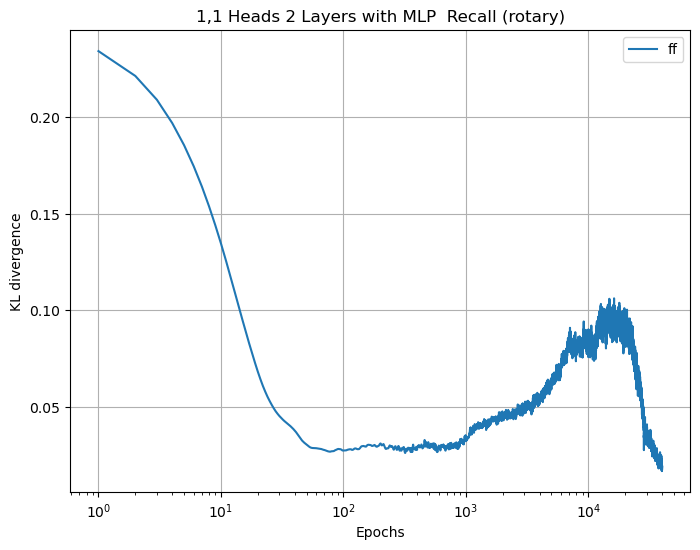

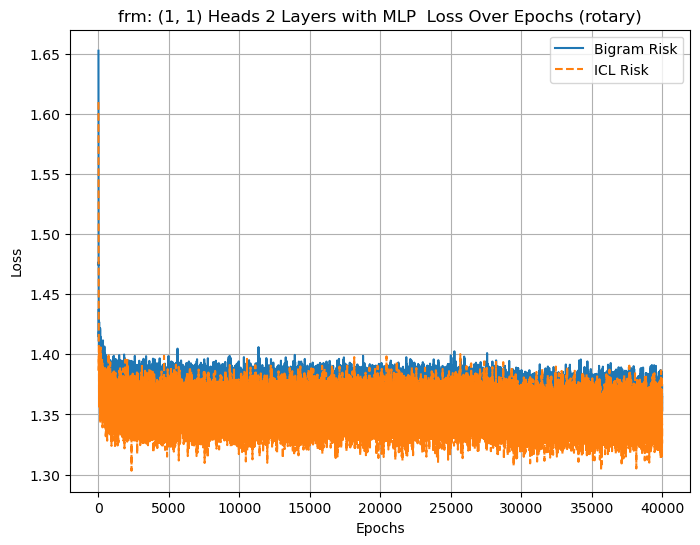

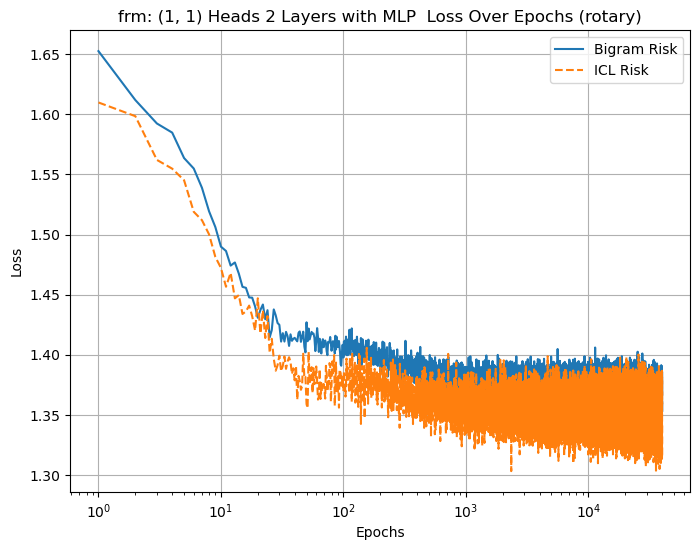

Creating images:   0%|          | 0/800 [00:00<?, ?it/s]

Creating images:   0%|          | 0/800 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

In [9]:
train_results, model = run_exp(SEQ_LEN, VOC_SIZE, BATCH_SIZE, rho, alpha, fixed=True, pos_enc="rotary", mlp_layer=1)

### Check Memorization for Rotary

In [15]:
train_results["sampler"].base_trans_matrix[1]

tensor([0.51, 0.06, 0.10, 0.12, 0.20], device='cuda:0')

In [16]:
toks = model.embed(torch.tensor([1], device="cuda"))
mlp_out = model.layers[1].mlp(toks)
toks += mlp_out
toks = model.output_layer(toks)
probs = nn.Softmax(-1)(toks)
(probs.squeeze() - train_results["sampler"].base_trans_matrix[0]).abs()

tensor([0.26, 0.05, 0.19, 0.11, 0.22], device='cuda:0', grad_fn=<AbsBackward0>)

In [17]:
batch, mask = train_results["sampler"].test()
nn.Softmax(-1)(model(batch)[0])[batch==1][-3:]

tensor([[[0.09, 0.14, 0.04, 0.24, 0.50]]], device='cuda:0')


tensor([[0.52, 0.06, 0.10, 0.12, 0.20],
        [0.52, 0.06, 0.10, 0.12, 0.20],
        [0.52, 0.06, 0.10, 0.12, 0.20]], device='cuda:0',
       grad_fn=<SliceBackward0>)

### Check Generalization for Rotary

In [18]:
batch, mask = train_results["sampler"].test()
batch, mask

tensor([[[0.37, 0.04, 0.07, 0.37, 0.15]]], device='cuda:0')


(tensor([[0, 0, 3, 1, 0, 0, 3, 4, 1, 0, 3, 4, 1, 0, 3, 0, 0, 0, 2, 1, 1, 3, 2, 1,
          3, 1, 0, 3, 1, 1, 0, 2, 3, 1, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 0,
          0, 4]], device='cuda:0'),
 tensor([[1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
          0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
          1, 0]], device='cuda:0'))

In [19]:
nn.Softmax(-1)(model(batch)[0].squeeze())[mask[0]==1]

tensor([[0.27, 0.19, 0.19, 0.18, 0.18],
        [0.27, 0.19, 0.19, 0.18, 0.18],
        [0.28, 0.14, 0.14, 0.31, 0.14],
        [0.36, 0.12, 0.13, 0.26, 0.12],
        [0.34, 0.11, 0.11, 0.35, 0.10],
        [0.29, 0.10, 0.10, 0.42, 0.10],
        [0.26, 0.09, 0.09, 0.48, 0.09],
        [0.34, 0.08, 0.08, 0.41, 0.08],
        [0.40, 0.08, 0.08, 0.37, 0.08],
        [0.35, 0.07, 0.14, 0.38, 0.06],
        [0.31, 0.07, 0.13, 0.43, 0.06],
        [0.30, 0.07, 0.18, 0.39, 0.06],
        [0.28, 0.06, 0.17, 0.43, 0.06],
        [0.33, 0.06, 0.16, 0.40, 0.06],
        [0.37, 0.06, 0.15, 0.37, 0.05],
        [0.40, 0.05, 0.14, 0.35, 0.05],
        [0.42, 0.05, 0.14, 0.33, 0.05],
        [0.45, 0.05, 0.14, 0.32, 0.05],
        [0.47, 0.05, 0.13, 0.30, 0.05],
        [0.49, 0.05, 0.12, 0.29, 0.05],
        [0.52, 0.05, 0.11, 0.28, 0.04],
        [0.49, 0.04, 0.11, 0.31, 0.04],
        [0.51, 0.04, 0.11, 0.29, 0.04]], device='cuda:0',
       grad_fn=<IndexBackward0>)